# Identify the Artist

In [1]:
from pathlib import Path, PurePath

home_dir = Path.home()
main_dir = home_dir / "OneDrive - BOOZ ALLEN HAMILTON"/"Documents" / "GitHub" / "bah-advanced" / "Capstone"
data_dir = main_dir / "archive" 
image_dir = data_dir / "images" /"images"
resized_dir = data_dir / "resized" / "resized"

In [46]:
# Import libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from textwrap import wrap
from datetime import datetime
import random
import seaborn as sns
from sklearn.metrics import *


import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import *

tf.random.set_seed(1)

In [3]:
# Load data
artists = pd.read_csv(data_dir / 'artists.csv')
artists.shape

(50, 8)

In [4]:
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'Vincent van Gogh'),
  Text(1, 0, 'Edgar Degas'),
  Text(2, 0, 'Pablo Picasso'),
  Text(3, 0, 'Pierre-Auguste Renoir'),
  Text(4, 0, 'Albrecht Dürer'),
  Text(5, 0, 'Paul Gauguin'),
  Text(6, 0, 'Francisco Goya'),
  Text(7, 0, 'Rembrandt'),
  Text(8, 0, 'Alfred Sisley'),
  Text(9, 0, 'Titian'),
  Text(10, 0, 'Marc Chagall'),
  Text(11, 0, 'Rene Magritte'),
  Text(12, 0, 'Amedeo Modigliani'),
  Text(13, 0, 'Paul Klee'),
  Text(14, 0, 'Henri Matisse'),
  Text(15, 0, 'Andy Warhol'),
  Text(16, 0, 'Mikhail Vrubel'),
  Text(17, 0, 'Sandro Botticelli'),
  Text(18, 0, 'Leonardo da Vinci'),
  Text(19, 0, 'Peter Paul Rubens'),
  Text(20, 0, 'Salvador Dali'),
  Text(21, 0, 'Hieronymus Bosch'),
  Text(22, 0, 'Pieter Bruegel'),
  Text(23, 0, 'Diego Velazquez'),
  Text(24, 0, 'Kazimir Malevich'),
  Text(25, 0, 'Frida Kahlo'),
  Text(26, 0, 'Giotto di

<Figure size 432x288 with 0 Axes>

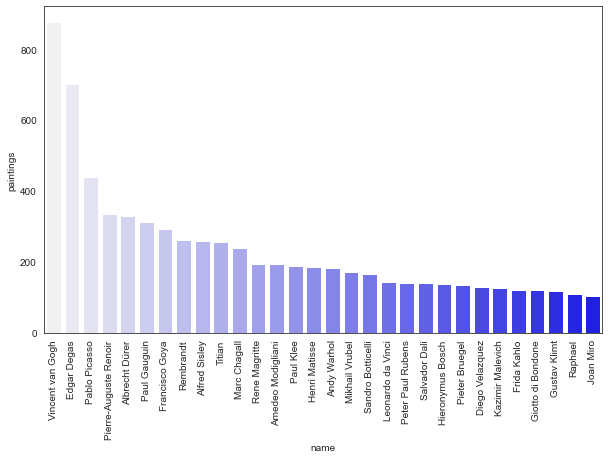

In [60]:
sns.set_style("white")
sns.despine()
plt.figure(figsize=(10, 6))
sns.barplot(data=artists_top, x="name", y="paintings", palette="light:b")

plt.xticks(rotation = 90)

In [5]:
# sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 100 paintings
artists_top = artists[artists['paintings'] >= 100].reset_index()
artists_top = artists_top[['name', 'paintings']]

#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.269517
1,Edgar Degas,702,0.336705
2,Pablo Picasso,439,0.538421
3,Pierre-Auguste Renoir,336,0.703472
4,Albrecht Dürer,328,0.720630
5,Paul Gauguin,311,0.760021
6,Francisco Goya,291,0.812257
7,Rembrandt,262,0.902163
8,Alfred Sisley,259,0.912613
9,Titian,255,0.926928


In [6]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.269517293804637,
 1: 0.33670465337132005,
 2: 0.5384206529992407,
 3: 0.7034722222222223,
 4: 0.720630081300813,
 5: 0.760021436227224,
 6: 0.8122565864833906,
 7: 0.9021628498727735,
 8: 0.9126126126126126,
 9: 0.9269281045751634,
 10: 0.9889818688981868,
 11: 1.2183848797250858,
 12: 1.2246977547495683,
 13: 1.2572695035460992,
 14: 1.2707885304659499,
 15: 1.3058931860036833,
 16: 1.382261208576998,
 17: 1.441260162601626,
 18: 1.652913752913753,
 19: 1.6763593380614656,
 20: 1.7004796163069544,
 21: 1.7253041362530415,
 22: 1.7639303482587065,
 23: 1.8466145833333334,
 24: 1.875925925925926,
 25: 1.9697222222222222,
 26: 1.9862745098039216,
 27: 2.0202279202279203,
 28: 2.1685015290519876,
 29: 2.3173202614379087}

## Data Processing

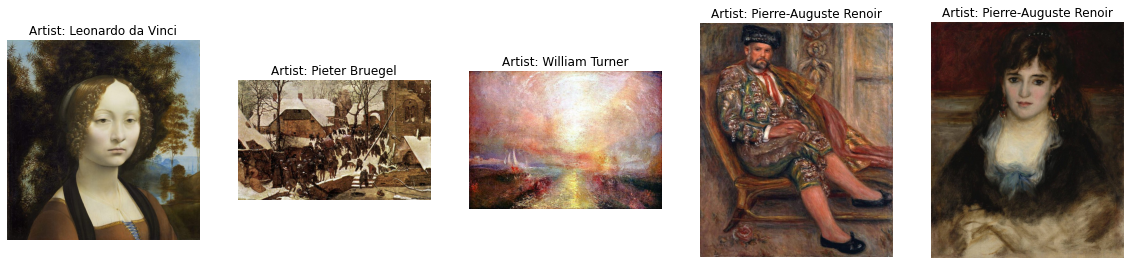

In [7]:
# Print few random paintings

n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
       
    random_image = random.choice(os.listdir(resized_dir))
    random_image_file = os.path.join(resized_dir, random_image)
    
    image = plt.imread(random_image_file)
    
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_image.rsplit('_', 1)[0].replace('_',' '))
    axes[i].axis('off')

plt.show()

## Data Augmentation


In [8]:
artists_top.shape[0]

30

In [18]:

batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

artists_top_name = artists_top['name'].str.replace(' ', '_').values

train_datagen = ImageDataGenerator(validation_split=0.2,
                                    rescale=1./255,
                                    shear_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True)

#test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(directory=image_dir,
                                                    target_size= train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    subset="training",
                                                    class_mode='categorical',
                                                    classes=artists_top_name.tolist())

validation_generator = train_datagen.flow_from_directory(directory=image_dir,
                                                        target_size=train_input_shape[0:2],
                                                        batch_size=batch_size,
                                                        subset="validation",
                                                        class_mode='categorical',
                                                        shuffle=True,
                                                        classes=artists_top_name.tolist())

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)



Found 5687 images belonging to 30 classes.
Found 1404 images belonging to 30 classes.
Total number of batches = 355 and 87


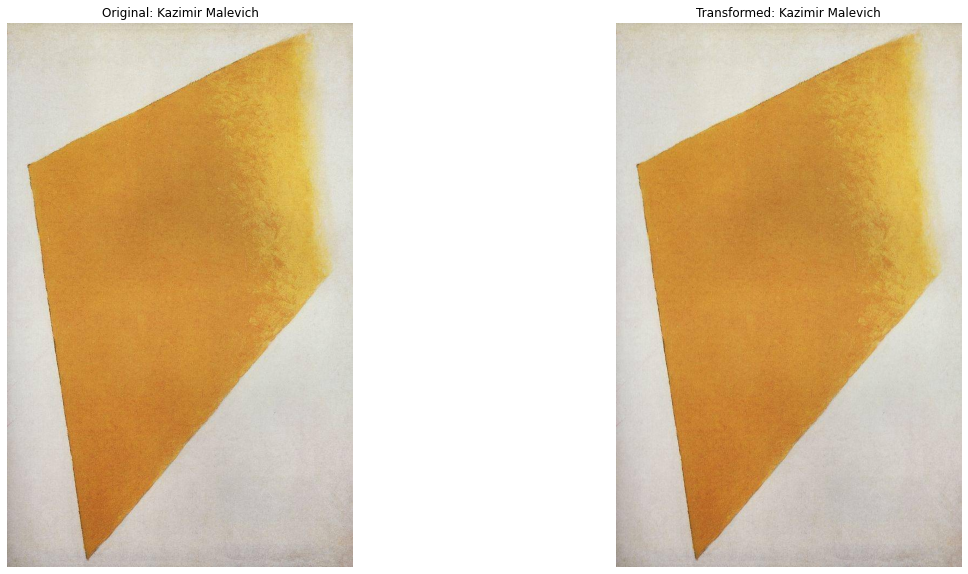

In [30]:
# print a random augmented version of a painting

fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(image_dir, random_artist)))
random_image_file = os.path.join(image_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("Original: " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("Transformed: " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

## Model Building

In [31]:
# Load pre-trained model

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

In [32]:
# Add additional layers

X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [33]:
# compile model

optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [34]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [35]:
#Train model

n_epoch = 50
history1 = model.fit_generator(generator=train_generator, 
                               steps_per_epoch=STEP_SIZE_TRAIN,
                               validation_data=validation_generator, 
                               validation_steps=STEP_SIZE_VALID,
                               epochs=n_epoch,
                               shuffle=True,
                               verbose=1,
                               callbacks=[reduce_lr],
                               #use_multiprocessing=True,
                               workers=16,
                               class_weight=class_weights
                              )

Epoch 1/50
355/355 [==============================] - 1431s 4s/step - loss: 3.0720 - accuracy: 0.1558 - val_loss: 5.8736 - val_accuracy: 0.0244
Epoch 2/50
355/355 [==============================] - 1453s 4s/step - loss: 2.4315 - accuracy: 0.3898 - val_loss: 3.8675 - val_accuracy: 0.0524
Epoch 3/50
355/355 [==============================] - 1458s 4s/step - loss: 2.1789 - accuracy: 0.4776 - val_loss: 2.6813 - val_accuracy: 0.3614
Epoch 4/50
355/355 [==============================] - 1428s 4s/step - loss: 1.9390 - accuracy: 0.5659 - val_loss: 2.2612 - val_accuracy: 0.4885
Epoch 5/50
355/355 [==============================] - 1453s 4s/step - loss: 1.7581 - accuracy: 0.6002 - val_loss: 2.3093 - val_accuracy: 0.4878
Epoch 6/50
355/355 [==============================] - 1486s 4s/step - loss: 1.6151 - accuracy: 0.6425 - val_loss: 2.1066 - val_accuracy: 0.5769
Epoch 7/50
355/355 [==============================] - 1473s 4s/step - loss: 1.4747 - accuracy: 0.6792 - val_loss: 2.1581 - val_accuracy:

In [ ]:
model.save('Resnet50_epoch50.h5')

## Graphs

In [36]:
history = {}
history['loss'] = history1.history['loss'] #+ history2.history['loss']
history['accuracy'] = history1.history['accuracy'] #+ history2.history['acc']
history['val_loss'] = history1.history['val_loss'] #+ history2.history['val_loss']
history['val_accuracy'] = history1.history['val_accuracy'] #+ history2.history['val_acc']
history['lr'] = history1.history['lr'] #+ history2.history['lr']

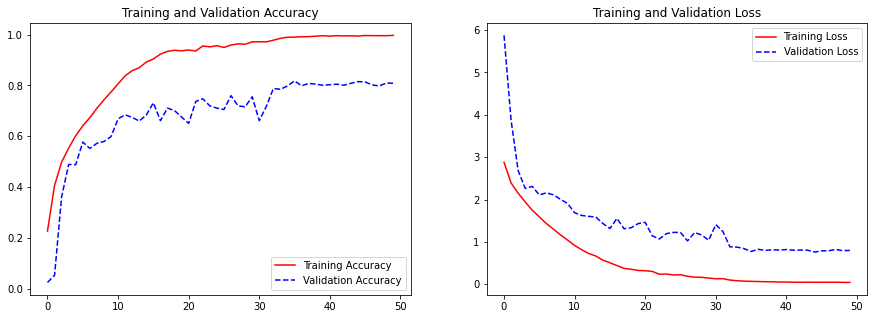

In [37]:
def plot_training(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.savefig("trial8_50epoch_nootherchanges.png")
    plt.show()
    
plot_training(history)

## Evaluation

In [38]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

356/356 [==============================] - 233s 653ms/step - loss: 0.0285 - accuracy: 1.0000
Prediction accuracy on train data = 1.0


In [39]:
# Prediction accuracy on CV data
score = model.evaluate_generator(validation_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

88/88 [==============================] - 57s 647ms/step - loss: 0.7945 - accuracy: 0.8148
Prediction accuracy on CV data = 0.8148148059844971


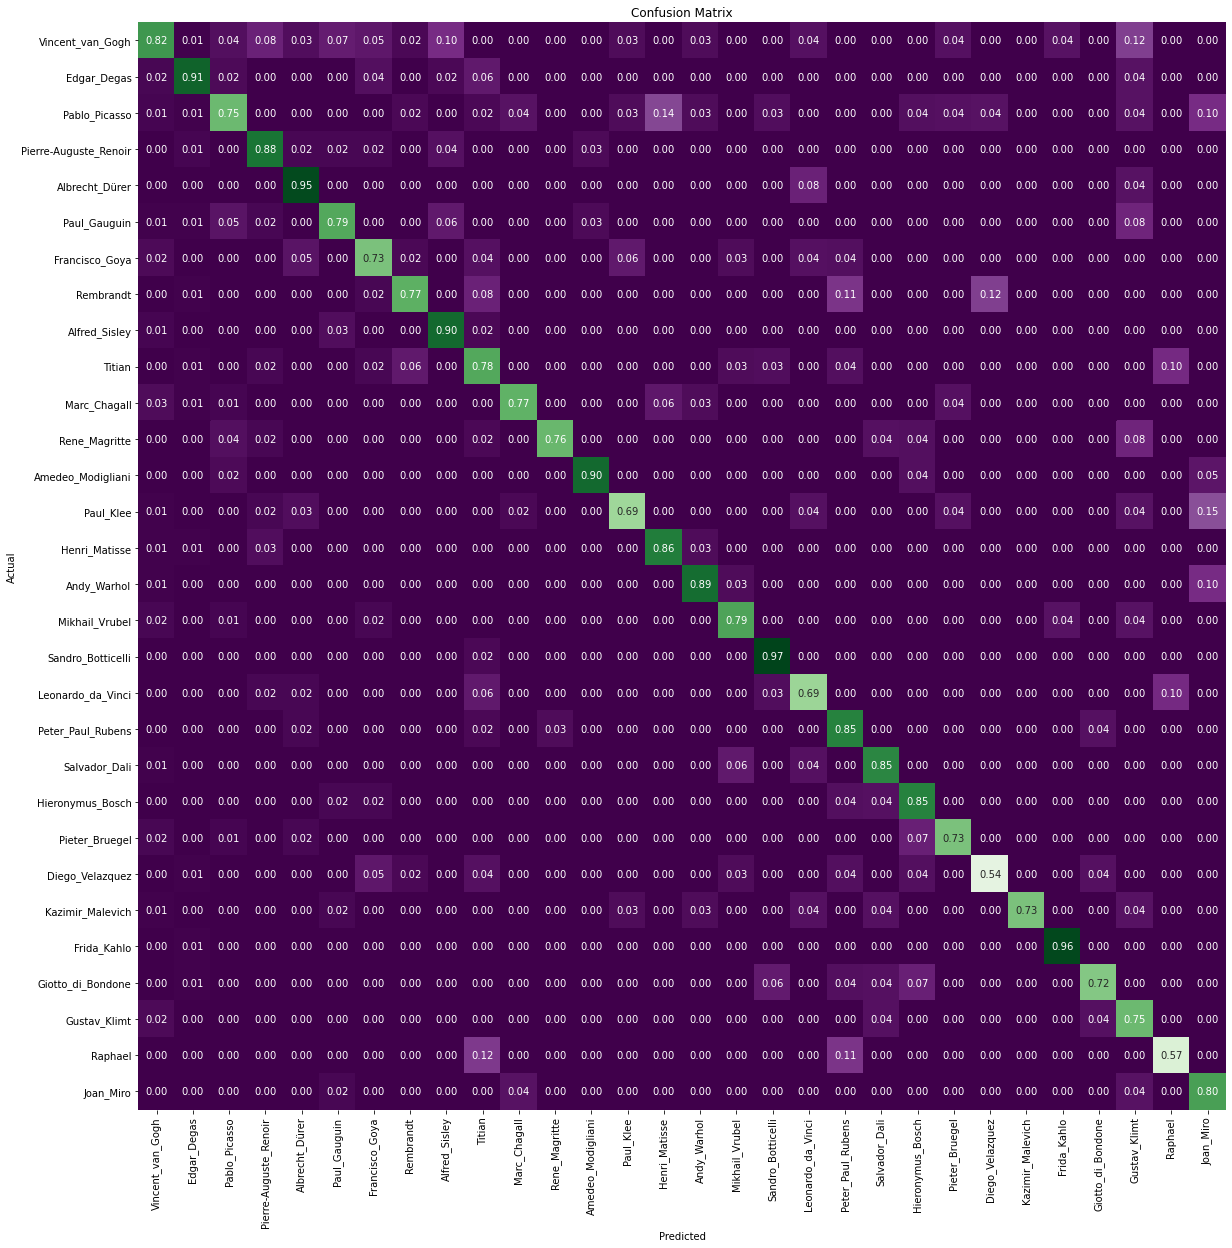

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.82      0.82      0.82       175
          Edgar_Degas       0.91      0.91      0.91       135
        Pablo_Picasso       0.79      0.75      0.77        85
Pierre-Auguste_Renoir       0.83      0.88      0.85        65
       Albrecht_Dürer       0.85      0.95      0.90        65
         Paul_Gauguin       0.83      0.79      0.81        61
       Francisco_Goya       0.76      0.73      0.75        56
            Rembrandt       0.85      0.77      0.81        52
        Alfred_Sisley       0.80      0.90      0.85        50
               Titian       0.62      0.78      0.69        51
         Marc_Chagall       0.88      0.77      0.82        47
        Rene_Magritte       0.97      0.76      0.85        37
    Amedeo_Modigliani       0.95      0.90      0.92        39
            Paul_Klee       0.83      0.69      0.75        35
        Henri_Matisse       0.8

In [44]:
# Classification Report and confusion matrix

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, validation_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(validation_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(20,20))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap='PRGn', xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, validation_generator, STEP_SIZE_VALID)

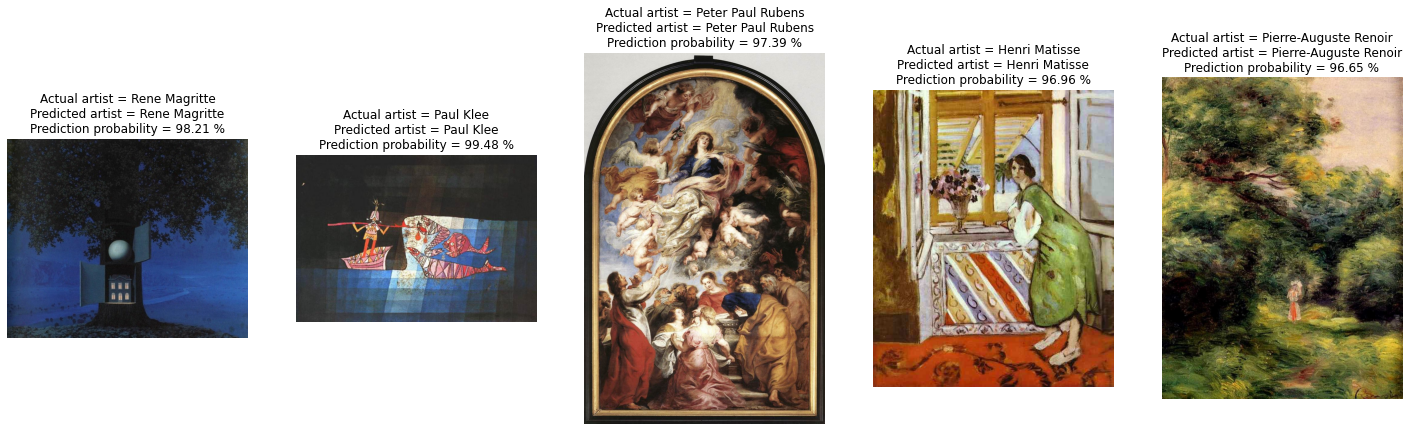

In [49]:
# Prediction


n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(image_dir, random_artist)))
    random_image_file = os.path.join(image_dir, random_artist, random_image)

    # Original image
    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()